# valid set 생성

대화 턴 수 통계:
1 Turn: 180회 (90.00%)
3 Turn: 20회 (10.00%)


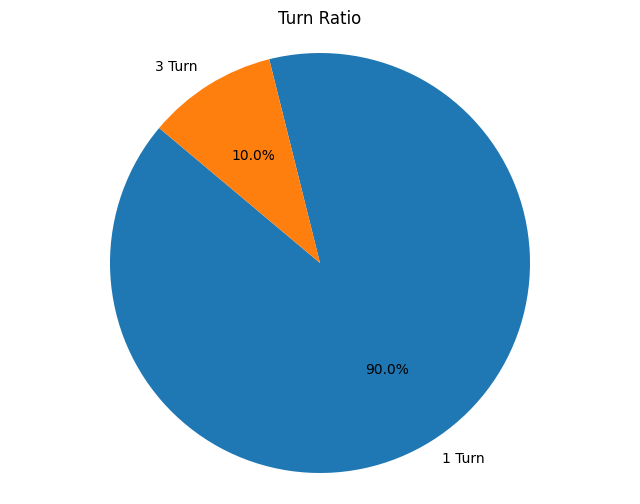

In [3]:
import json
import matplotlib.pyplot as plt

# JSONL 파일 경로
jsonl_file_path = 'data/eval_without_smalltalk.jsonl'

# 대화 턴 수를 저장할 리스트
turn_counts = []

# JSONL 파일 읽기
with open(jsonl_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        data = json.loads(line.strip())
        # 대화의 턴 수를 계산하여 리스트에 추가
        turn_counts.append(len(data['msg']))

# 각 턴 수의 빈도수 계산
turn_frequency = {}
for count in turn_counts:
    if count in turn_frequency:
        turn_frequency[count] += 1
    else:
        turn_frequency[count] = 1

# 전체 대화 수 계산
total_conversations = len(turn_counts)

# 결과 출력
print("대화 턴 수 통계:")
for turn, frequency in turn_frequency.items():
    ratio = (frequency / total_conversations) * 100  # 비율 계산
    print(f"{turn} Turn: {frequency}회 ({ratio:.2f}%)")

# 파이차트 그리기
labels = [f"{turn} Turn" for turn in turn_frequency.keys()]
sizes = list(turn_frequency.values())
colors = plt.cm.tab10.colors  # Matplotlib의 기본 색상 팔레트 사용

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # 원형으로 유지
plt.title('Turn Ratio')
plt.show()

### 전체 documents에서 랜덤으로 용도에 맞는 아이템 나누기

In [4]:
import random

def split_jsonl_file(input_file, output_files, percentages):
    with open(input_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    random.shuffle(lines)

    total_lines = len(lines)
    split_indices = [int(total_lines * p) for p in percentages]

    # 각각의 파일에 저장
    start_idx = 0
    for idx, output_file in zip(split_indices, output_files):
        with open(output_file, 'w', encoding='utf-8') as f_out:
            f_out.writelines(lines[start_idx:start_idx + idx])
            start_idx += idx

# 사용 예시
input_file = './data/documents.jsonl'  # 원본 JSONL 파일 경로
output_files = ['./data/documents_25.jsonl', './data/documents_70.jsonl', './data/documents_5.jsonl']  # 출력 파일 경로
percentages = [0.25, 0.7, 0.05]  # 1turn, 1turn 유의어, 3turn 비율

split_jsonl_file(input_file, output_files, percentages)

### 각 용도에 맞는 질문 생성

In [5]:
import transformers
import torch

model_id = "rtzr/ko-gemma-2-9b-it"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
def request_prompt(message, max_new_tokens=100, temperature=None):
    with torch.no_grad():  # cuda 메모리 확보하기 위해 
        try:
            prompt = pipeline.tokenizer.apply_chat_template(
                message, 
                tokenize=False, 
                add_generation_prompt=True
            )

            terminators = [
                pipeline.tokenizer.eos_token_id,
                pipeline.tokenizer.convert_tokens_to_ids("<end_of_turn>")
            ]

            do_sample = True if temperature else False
            
            outputs = pipeline(
                prompt,
                max_new_tokens=max_new_tokens,
                eos_token_id=terminators,
                do_sample=do_sample,
                temperature=temperature,
            )
            return outputs[0]["generated_text"][len(prompt):]
        except Exception as e:
            print(e)
            return ""

In [7]:
persona_normal_single_turn = """당신은 과학 기술에 특화된 상식 RAG 시스템입니다.
참조 문서를 보고, Validation Set으로 사용할 user 대화를 1개 생성해주세요.
**출력 예시**: 다음의 JSON 포맷으로 작성해주세요.
   - {"msg": [{"role": "user", "content": "솔레노이드가 뭐야?"}]}
   - {"msg": [{"role": "user", "content": "다양한 책을 catalog화 하는 코드에서 class 정의 방법 알려줘."}]}
   - {"msg": [{"role": "user", "content": "여행을 통해 얻을 수 있는 좋은 점들이 뭐가 있어?"}]}
**주의사항**:
   - 응답은 반드시 예시처럼 **JSON Body 만** 출력하세요.
"""
print(persona_normal_single_turn)

당신은 과학 기술에 특화된 상식 RAG 시스템입니다.
참조 문서를 보고, Validation Set으로 사용할 user 대화를 1개 생성해주세요.
**출력 예시**: 다음의 JSON 포맷으로 작성해주세요.
   - {"msg": [{"role": "user", "content": "솔레노이드가 뭐야?"}]}
   - {"msg": [{"role": "user", "content": "다양한 책을 catalog화 하는 코드에서 class 정의 방법 알려줘."}]}
   - {"msg": [{"role": "user", "content": "여행을 통해 얻을 수 있는 좋은 점들이 뭐가 있어?"}]}
**주의사항**:
   - 응답은 반드시 예시처럼 **JSON Body 만** 출력하세요.



In [8]:
persona_normal_triple_turn = """당신은 과학 기술에 특화된 상식 RAG 시스템입니다.
참조 문서를 보고, Validation Set으로 사용할 user-assistant-user 3turn 대화를 1개 생성해주세요.
**출력 예시**: 다음의 JSON 포맷으로 작성해주세요.
   - {"msg": [{"role": "user", "content": "Python 공부중이야."}, {"role": "assistant", "content": "네 python은 배워 두시면 유용합니다."}, {"role": "user", "content": "list의 값중 가장 작은 값을 알려주는 함수가 뭐야?"}]}
   - {"msg": [{"role": "user", "content": "동물들이 종종 집단으로 이주하는 경우가 발생하더라구?"}, {"role": "assistant", "content": "네 맞습니다."}, {"role": "user", "content": "이렇게 집단으로 이주하게 되는 계기는 어떤 것들이 있어?"}]}
   - {"msg": [{"role": "user", "content": "은하들이 점점 멀어지고 있다던데 맞아?"}, {"role": "assistant", "content": "네 맞아요."}, {"role": "user", "content": "어떤 물리적인 현상을 보고 그걸 알게 되었어?"}]}
**주의사항**:
   - 응답은 반드시 예시처럼 **JSON Body 만** 출력하세요.
"""
print(persona_normal_triple_turn)

당신은 과학 기술에 특화된 상식 RAG 시스템입니다.
참조 문서를 보고, Validation Set으로 사용할 user-assistant-user 3turn 대화를 1개 생성해주세요.
**출력 예시**: 다음의 JSON 포맷으로 작성해주세요.
   - {"msg": [{"role": "user", "content": "Python 공부중이야."}, {"role": "assistant", "content": "네 python은 배워 두시면 유용합니다."}, {"role": "user", "content": "list의 값중 가장 작은 값을 알려주는 함수가 뭐야?"}]}
   - {"msg": [{"role": "user", "content": "동물들이 종종 집단으로 이주하는 경우가 발생하더라구?"}, {"role": "assistant", "content": "네 맞습니다."}, {"role": "user", "content": "이렇게 집단으로 이주하게 되는 계기는 어떤 것들이 있어?"}]}
   - {"msg": [{"role": "user", "content": "은하들이 점점 멀어지고 있다던데 맞아?"}, {"role": "assistant", "content": "네 맞아요."}, {"role": "user", "content": "어떤 물리적인 현상을 보고 그걸 알게 되었어?"}]}
**주의사항**:
   - 응답은 반드시 예시처럼 **JSON Body 만** 출력하세요.



In [9]:
persona_synonyms_single_turn = """당신은 과학 기술에 특화된 상식 RAG 시스템입니다.
참조 문서를 보고, Validation Set으로 사용할 user 대화를 1개 생성해주세요.
생성 대화의 핵심 단어는 **비슷한 단어**로 바꿔야 합니다.
**단어 변경 예시**:
1.
-before: 시냅스 간극에서 효소가 변성되면 아세틸콜린의 생명주기는 어떻게 변화할까요?
-after: 신경 접합부에서 효소가 변성되면 아세틸콜린의 생명주기는 어떻게 변화할까요?
2.
-before: beaver 개체수 감소가 생태계에 미치는 영향은 무엇일까요?
-after: 비버 개체수 감소가 생태계에 미치는 영향은 무엇일까요?
3.
-before: 인터넷 프록시가 하는 일을 간단하게 설명해주세요.
-after: 인터넷 Proxy가 하는 일을 간단하게 설명해주세요.
4.
-before: 고정행동양식이란 무엇이며, 예시를 들어 설명해주세요.
-after: 고정행동패턴이란 무엇이며, 예시를 들어 설명해주세요.
5.
-before: 래브라도 리트리버의 유전형이 Bbee라면 털 색깔은 어떻게 될까요?
-after: 랩래드도 리트리버의 유전형이 Bbee라면 털 색깔은 어떻게 될까요?
**출력 예시**: 다음의 JSON 포맷으로 작성해주세요.
   - {"msg": [{"role": "user", "content": "바닷물 말고 담수가 가장 많이 있는 곳이 어디야?"}]}
**주의사항**:
   - 응답은 반드시 예시처럼 **JSON Body 만** 출력하세요.
"""
print(persona_synonyms_single_turn)

당신은 과학 기술에 특화된 상식 RAG 시스템입니다.
참조 문서를 보고, Validation Set으로 사용할 user 대화를 1개 생성해주세요.
생성 대화의 핵심 단어는 **비슷한 단어**로 바꿔야 합니다.
**단어 변경 예시**:
1.
-before: 시냅스 간극에서 효소가 변성되면 아세틸콜린의 생명주기는 어떻게 변화할까요?
-after: 신경 접합부에서 효소가 변성되면 아세틸콜린의 생명주기는 어떻게 변화할까요?
2.
-before: beaver 개체수 감소가 생태계에 미치는 영향은 무엇일까요?
-after: 비버 개체수 감소가 생태계에 미치는 영향은 무엇일까요?
3.
-before: 인터넷 프록시가 하는 일을 간단하게 설명해주세요.
-after: 인터넷 Proxy가 하는 일을 간단하게 설명해주세요.
4.
-before: 고정행동양식이란 무엇이며, 예시를 들어 설명해주세요.
-after: 고정행동패턴이란 무엇이며, 예시를 들어 설명해주세요.
5.
-before: 래브라도 리트리버의 유전형이 Bbee라면 털 색깔은 어떻게 될까요?
-after: 랩래드도 리트리버의 유전형이 Bbee라면 털 색깔은 어떻게 될까요?
**출력 예시**: 다음의 JSON 포맷으로 작성해주세요.
   - {"msg": [{"role": "user", "content": "바닷물 말고 담수가 가장 많이 있는 곳이 어디야?"}]}
**주의사항**:
   - 응답은 반드시 예시처럼 **JSON Body 만** 출력하세요.



In [10]:
persona_smalltalk_single_turn = """당신은 잡담 챗봇입니다.
Validation Set으로 사용할 user 1turn 대화를 1개 생성해주세요. 요청받은 주제로 가벼운 대화를 생성합니다. 
**출력 예시**: 다음의 JSON 포맷으로 작성해주세요.
   - {"msg": [{"role": "user", "content": "니가 모르는 건 뭐야?"}]}
   - {"msg": [{"role": "user", "content": "이제 자야겠어. 또 보자."}]}
   - {"msg": [{"role": "user", "content": "날씨가 너무 더운데 무서운 얘기 좀 해줘."}]}
**주의사항**:
   - 응답은 반드시 예시처럼 **JSON Body 만** 출력하세요.
"""
print(persona_smalltalk_single_turn)

당신은 잡담 챗봇입니다.
Validation Set으로 사용할 user 1turn 대화를 1개 생성해주세요. 요청받은 주제로 가벼운 대화를 생성합니다. 
**출력 예시**: 다음의 JSON 포맷으로 작성해주세요.
   - {"msg": [{"role": "user", "content": "니가 모르는 건 뭐야?"}]}
   - {"msg": [{"role": "user", "content": "이제 자야겠어. 또 보자."}]}
   - {"msg": [{"role": "user", "content": "날씨가 너무 더운데 무서운 얘기 좀 해줘."}]}
**주의사항**:
   - 응답은 반드시 예시처럼 **JSON Body 만** 출력하세요.



In [11]:
import json
import re

def extract_fields(response):
    # 불필요한 부분 제거
    clean_response = re.sub(r'```json|```', '', response).strip()
    
    # 마지막 쉼표 제거
    clean_response = re.sub(r',\s*}$', '}', clean_response)

    # 추가적인 공백 제거
    clean_response = re.sub(r'\s+', ' ', clean_response)

    try:
        # JSON 파싱 시도
        result = json.loads(clean_response)
        result = result["msg"]
        return result
    except json.JSONDecodeError as e:
        # 파싱 실패 시 에러 위치 출력 및 처리
        print(f"JSON 파싱 실패({e.pos}): {e},")
        raise e
    except Exception as e:
        print(f"No Json Format: {e}")
        raise e

In [12]:
import json
import gc

def generate_data(input_filename, output_filename, persona, temperature):
    print(f">> {input_filename}")

    with open(input_filename) as f, open(output_filename, "w") as of:
        idx = 0

        for line in f:
            # print(f'[{idx}]')
            # if idx > 5:
            #   break
            
            j = json.loads(line)
            document = j["content"]
            # print(document)
            prompt = [{"role": "system", "content": persona}] + [{"role": "user", "content": document}]
            # print(f'prompt : {prompt}')
            response = request_prompt(prompt, 500, temperature)
            # print(f'plain : {response}')

            try:
                msg = extract_fields(response)
                output = {
                    "eval_id": idx,
                    "docid": j["docid"],
                    "msg": msg,
                }
                print(f'{json.dumps(output, ensure_ascii=False)}')

                # 수정된 JSON을 출력 파일에 저장
                of.write(f'{json.dumps(output, ensure_ascii=False)}\n')

            except Exception as e:
                id = j["docid"]
                print(f"++ Error! {id} : {e}")
                print(f'plain response : {response}')                

            idx += 1

            del response
            gc.collect()
            torch.cuda.empty_cache()

In [13]:
import json
import gc

def generate_smalltalk_data(output_filename, item_size, persona, subjects, temperature):
    print(f">> generate_smalltalk_data")
    
    generated_data = []
    content_set = set()  # 중복을 확인할 content set

    # 데이터를 먼저 메모리 상에 생성
    for i in range(item_size):
        subject = random.choice(subjects)
        print(f'subject : {subject}')
        prompt = [{"role": "system", "content": persona}] + [{"role": "user", "content": f"**주제**: {subject}"}]
        response = request_prompt(prompt, 200, temperature)
        print(f'plain : {response}')

        try:
            msg = extract_fields(response)
            content = msg[0].get('content', '')  # msg에서 content를 추출

            if content in content_set:
                print(f'Duplicate content found, skipping: {content}')
                continue  # 중복된 content가 있으면 해당 항목은 건너뜀

            content_set.add(content)  # 새로운 content는 set에 추가
            generated_data.append({
                "eval_id": i,  # 일단 초기 eval_id로 추가
                "docid": "",
                "msg": msg,
            })

        except Exception as e:
            print(f"++ Error! {e}")
            print(f'plain response : {response}')                

        del response
        gc.collect()
        torch.cuda.empty_cache()

    # 중복을 제거한 후 eval_id를 재정의하면서 파일로 출력
    with open(output_filename, "w", encoding="utf-8") as of:
        for new_id, item in enumerate(generated_data):
            item['eval_id'] = new_id  # eval_id를 새로 정의
            of.write(f'{json.dumps(item, ensure_ascii=False)}\n')
    
    print(f"Data generation complete. Total unique items: {len(generated_data)}")

In [14]:
from datetime import datetime
import time
from zoneinfo import ZoneInfo

current_time = datetime.fromtimestamp(time.time(), tz=ZoneInfo("Asia/Seoul")).strftime("%m%d-%H%M")

single_turn_synonyms_valid = f"./data/valid_1turn_synonyms_{current_time}.jsonl"
single_turn_normal_valid = f"./data/valid_1turn_{current_time}.jsonl"
triple_turn_normal_valid = f"./data/valid_3turn_{current_time}.jsonl"
single_turn_smalltalk_valid = f"./data/valid_1turn_smalltalk_{current_time}.jsonl"

sigle_turn_synonyms_documents = "./data/documents_70.jsonl"
sigle_turn_normal_documents = "./data/documents_25.jsonl"
triple_turn_normal_documents = "./data/documents_5.jsonl"
generate_data(sigle_turn_synonyms_documents, single_turn_synonyms_valid, persona_synonyms_single_turn, 0.7)
generate_data(sigle_turn_normal_documents, single_turn_normal_valid, persona_normal_single_turn, None)
generate_data(triple_turn_normal_documents, triple_turn_normal_valid, persona_normal_triple_turn, None)

subjects = ["당신에 대한 질문", "상대방에 대한 질문", "대화 종료", "일상 대화", "감정 표현"]
generate_smalltalk_data(single_turn_smalltalk_valid, 150, persona_smalltalk_single_turn, subjects, 0.5)

The 'max_batch_size' argument of HybridCache is deprecated and will be removed in v4.46. Use the more precisely named 'batch_size' argument instead.


>> ./data/documents_70.jsonl


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


{"eval_id": 0, "docid": "a3c53ff4-db35-4642-9077-37b16d0a1d12", "msg": [{"role": "user", "content": "별도의 도시 지역 말고 집중된 인구 지역이 가장 많은 곳은 어디일까요?"}]}
{"eval_id": 1, "docid": "e3a0232a-85d4-46df-a13e-0a0a60f77b9f", "msg": [{"role": "user", "content": "잉겔의 법칙이라는 개념은 급식 경제에서 수입과 식량 소비 비율 사이의 관계를 설명하는 법칙으로, 어떻게 작동하나요?"}]}
{"eval_id": 2, "docid": "7b330a31-2b19-4e18-bf89-5047db23e537", "msg": [{"role": "user", "content": "도구 갈등이 가장 잘 나타나는 게임이 있다면 무엇일까요?"}]}
{"eval_id": 3, "docid": "3d77e10e-aad1-4908-b069-fbd84efaf619", "msg": [{"role": "user", "content": "물고기 아닌 육상 동물 중 암석의 화학적 풍화에 가장 큰 영향을 미치는 생물체가 뭐예요?"}]}
{"eval_id": 4, "docid": "2fe9c75a-e8e9-4bff-a87c-6d1f3289fe55", "msg": [{"role": "user", "content": "제2차 세계전쟁 이후에도 불구하고, 거의 2/3의 미국 국민이 어느 나라에 인도적 지원을 제공하는 데 찬성했나요?"}]}
{"eval_id": 5, "docid": "39b3378c-db1f-43a6-8e7d-48d339349e4a", "msg": [{"role": "user", "content": "직류 동기기에서 6극 자기부채가 사용되고 병렬 회로의 수는 2개인 상황을 설명해 주세요."}]}
>> ./data/documents_25.jsonl
{"eval_id": 0, "docid": "05275e38-6f5a-4

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


{"eval_id": 3, "docid": "73089763-06d2-4395-b235-aa3e6a399531", "msg": [{"role": "user", "content": "용액의 농도를 나타내는 단위가 몇 가지가 있을까요? 그리고 각 단위가 무엇을 의미하는지 설명해주세요."}]}
{"eval_id": 4, "docid": "8018337f-15cb-4341-b6fa-e311b4372df9", "msg": [{"role": "user", "content": "석탄과 나무를 비교했을 때, 재생 가능 에너지원으로서 어떤 점이 더 나은가요?"}]}
{"eval_id": 5, "docid": "b58cc073-432d-4951-bce8-4b2f96867d13", "msg": [{"role": "user", "content": "주기율표에서 원소들을 구분하는 데 사용되는 물리적 성질이 뭔가요?"}]}
>> ./data/documents_5.jsonl
{"eval_id": 0, "docid": "11cca31a-3997-43fd-a04b-01a2e318d7a2", "msg": [{"role": "user", "content": "광자의 에너지와 관련된 중요한 요소가 뭔가요?"}, {"role": "assistant", "content": "광자의 에너지와 가장 밀접한 관련이 있는 요소는 진동수입니다."}, {"role": "user", "content": "진동수가 광자의 에너지에 어떤 영향을 미치나요?"}]}
{"eval_id": 1, "docid": "4b290740-1f2b-415c-9eed-011bd57c83f5", "msg": [{"role": "user", "content": "수조에 식물을 더 넣으면 어떤 효과가 있을까요?"}, {"role": "assistant", "content": "수조에 식물을 더 넣으면 산소량이 증가하고 수질이 개선됩니다. 식물은 광합성을 통해 이산화탄소를 흡수하고 산소를 방출하기 때문입니다."}, {"role": "user

### valid.jsonl 생성

##### test set(가답안) 비율 확인

In [15]:
import json
from collections import defaultdict, Counter

documents_file = './data/documents.jsonl'
eval_file = './data/eval.jsonl'
gt_items_file = './submissions/0.9250-0.9220.csv'
eval_prediction_file = './data/eval_prediction.jsonl'

def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

def save_jsonl(items, file_path):
    with open(file_path, 'w', encoding='utf-8') as f:
        for item in items:
            json.dump(item, f, ensure_ascii=False)
            f.write('\n')

def merge_documents(documents, eval_data, gt_items):
    documents_dict = {doc['docid']: doc for doc in documents}
    eval_dict = {e['eval_id']: e for e in eval_data}
    
    merged_items = []
    missing_items = []
    
    for item in gt_items:
        eval_id = item['eval_id']
        if not item['topk']:
            missing_items.append(('empty_topk', eval_id))
            continue
            
        first_docid = item['topk'][0]
        if first_docid not in documents_dict:
            missing_items.append(('missing_docid', eval_id, first_docid))
            continue
            
        merged_item = {**documents_dict[first_docid], 'eval_id': eval_id}
        if eval_id in eval_dict:
            merged_item['msg'] = eval_dict[eval_id].get('msg', [])
        merged_items.append(merged_item)
    
    return merged_items, missing_items

def calculate_turn_ratios(items):
    src_turn_count = defaultdict(list)
    total_turns_count = Counter()
    
    for item in items:
        turn_count = len(item.get('msg', []))
        src_turn_count[item['src']].append(turn_count)
        total_turns_count[turn_count] += 1
    
    src_turn_ratio = {}
    for src, turns in src_turn_count.items():
        total_turns = len(turns)
        turn_counts = Counter(turns)
        ratios = {turn: (count, count / total_turns * 100) for turn, count in turn_counts.items()}
        
        if ratios.get(1, (0, 0))[1] == 100:
            continue
        src_turn_ratio[src] = (ratios, total_turns)
    
    return src_turn_ratio, total_turns_count

documents = load_jsonl(documents_file)
eval_data = load_jsonl(eval_file)
gt_items = load_jsonl(gt_items_file)

print(f"\n총 gt_items 개수: {len(gt_items)}")
print(f"topk가 있는 항목 수: {sum(1 for item in gt_items if item['topk'])}")

# 문서 병합
merged_items, missing_items = merge_documents(documents, eval_data, gt_items)

# 병합된 아이템 저장
save_jsonl(merged_items, eval_prediction_file)
print(f"\n병합된 아이템을 {eval_prediction_file}에 저장했습니다.")

print("\n++ Missing Items:")
for missing_item in missing_items:
    if missing_item[0] == 'empty_topk':
        print(f"Empty topk for eval_id: {missing_item[1]}")
    else:
        print(f"Missing docid: {missing_item[2]} for eval_id: {missing_item[1]}")

# src 비율 및 턴 비율 계산
src_turn_ratio, total_turns_count = calculate_turn_ratios(merged_items)

print(f"\n총 처리된 항목 수: {len(merged_items)}")
print("\n++ Total Turn Counts:")
total_items = sum(total_turns_count.values())
for turn, count in sorted(total_turns_count.items()):
    print(f"{turn} turns: {count}개 ({count/total_items*100:.2f}%)")

print("\n++ Turn Count Ratio per Source:")
for src, (turn_ratios, total_turns) in src_turn_ratio.items():
    print(f"\nSource: {src} (총 개수: {total_turns})")
    for turn, (count, ratio) in sorted(turn_ratios.items()):
        print(f"{turn} turns: {count}개 ({ratio:.2f}%)")


총 gt_items 개수: 220
topk가 있는 항목 수: 200

병합된 아이템을 ./data/eval_prediction.jsonl에 저장했습니다.

++ Missing Items:
Empty topk for eval_id: 2
Empty topk for eval_id: 32
Empty topk for eval_id: 57
Empty topk for eval_id: 64
Empty topk for eval_id: 67
Empty topk for eval_id: 83
Empty topk for eval_id: 90
Empty topk for eval_id: 94
Empty topk for eval_id: 103
Empty topk for eval_id: 218
Empty topk for eval_id: 220
Empty topk for eval_id: 222
Empty topk for eval_id: 227
Empty topk for eval_id: 229
Empty topk for eval_id: 245
Empty topk for eval_id: 247
Empty topk for eval_id: 261
Empty topk for eval_id: 276
Empty topk for eval_id: 283
Empty topk for eval_id: 301

총 처리된 항목 수: 200

++ Total Turn Counts:
1 turns: 180개 (90.00%)
3 turns: 20개 (10.00%)

++ Turn Count Ratio per Source:

Source: high_school_computer_science (총 개수: 5)
1 turns: 2개 (40.00%)
3 turns: 3개 (60.00%)

Source: global_facts (총 개수: 8)
1 turns: 7개 (87.50%)
3 turns: 1개 (12.50%)

Source: ARC_Challenge (총 개수: 97)
1 turns: 85개 (87.63%)
3 tur

##### Test Set 가답안의 documents 제외

In [48]:
import json
from json.decoder import JSONDecodeError

def read_valid_lines(filename):
    valid_lines = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, 1):
            line = line.strip()
            if not line:  # 빈 줄 건너뛰기
                continue
            try:
                data = json.loads(line)
                valid_lines.append(data)
            except JSONDecodeError as e:
                print(f"Warning: JSON 파싱 에러 (파일: {filename}, 줄: {line_number})")
                print(f"에러 내용: {str(e)}")
                print(f"문제의 줄: {line}")
    return valid_lines

def generate_validset(eval_prediction_file, valid_file, valid_filtered_file):
    print(f">> {valid_file}")
    
    try:
        eval_data = read_valid_lines(eval_prediction_file)
        eval_ids = set(data['eval_id'] for data in eval_data if 'eval_id' in data)
    except FileNotFoundError:
        print(f"{eval_prediction_file} 파일을 찾을 수 없습니다.")
        exit(1)

    try:
        valid_data = read_valid_lines(valid_file)
        filtered_data = [data for data in valid_data if 'eval_id' in data and data['eval_id'] not in eval_ids]
    except FileNotFoundError:
        print(f"{valid_file} 파일을 찾을 수 없습니다.")
        exit(1)

    # 필터링된 데이터를 새로운 파일에 저장
    try:
        with open(valid_filtered_file, 'w', encoding='utf-8') as f:
            for data in filtered_data:
                json_str = json.dumps(data, ensure_ascii=False)
                f.write(json_str + '\n')
    except IOError as e:
        print(f"{valid_filtered_file} 파일 저장 중 에러 발생: {str(e)}")
        exit(1)

    print(f"원본 데이터 수: {len(valid_data)}")
    print(f"제외된 eval_id 수: {len(eval_ids)}")
    print(f"필터링된 데이터 수: {len(filtered_data)}")

valid_1turn_normal_filtered = f'./data/valid_1turn_normal_{current_time}_filtered.jsonl'
generate_validset(eval_prediction_file, single_turn_normal_valid, valid_1turn_normal_filtered)

valid_1turn_synonyms_filtered = f'./data/valid_1turn_synonyms_{current_time}_filtered.jsonl'
generate_validset(eval_prediction_file, single_turn_synonyms_valid, valid_1turn_synonyms_filtered)

valid_3turn_normal_filtered = f'./data/valid_3turn_normal_{current_time}_filtered.jsonl'
generate_validset(eval_prediction_file, triple_turn_normal_valid, valid_3turn_normal_filtered)

>> ./data/valid_1turn_synonyms_1019-0203.jsonl
원본 데이터 수: 2989
제외된 eval_id 수: 200
필터링된 데이터 수: 2789
>> ./data/valid_1turn_normal_1019-0203.jsonl
에러 내용: Expecting value: line 1 column 1 (char 0)
문제의 줄: >> normal_triple_turn
에러 내용: Expecting value: line 1 column 1 (char 0)
문제의 줄: JSON 파싱 실패(249): Expecting value: line 1 column 250 (char 249),
에러 내용: Expecting value: line 1 column 1 (char 0)
문제의 줄: ++ Error! 78a3e002-e426-4766-b891-f2bd7a26ace3 : Expecting value: line 1 column 250 (char 249)
에러 내용: Expecting value: line 1 column 1 (char 0)
문제의 줄: plain response : ```json
에러 내용: Expecting value: line 1 column 250 (char 249)
문제의 줄: {"msg": [{"role": "user", "content": "성 선택 이론이란 무엇인가요?"}, {"role": "assistant", "content": "성 선택 이론은 사회생물학자들이 특히 성별 차이의 진화를 설명하는 데 사용하는 이론입니다. 동물들이 번식 파트너를 선택할 때 특정한 특성을 선호하는 경향을 말하는 거예요."}, {"role": "user", "content": "그 특성이 유리하게 작용하는 이유는 무엇일까요?"},]}
에러 내용: Expecting value: line 1 column 1 (char 0)
문제의 줄: ```
에러 내용: Expecting value: line 1 column 1 (char 0)
문제의 줄:

In [51]:
import json
import random

def read_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def sample_items(data, num_items):
    return random.sample(data, num_items)

def merge_random_selection(files_and_percentages, total_items, output_file):
    merged_data = []
    remaining_items = total_items
    
    # 파일의 데이터와 개수 저장
    file_data = {file_path: read_jsonl(file_path) for file_path, _ in files_and_percentages}
    
    # 가장 작은 비율을 가진 파일 추출
    min_percentage_file = min(files_and_percentages, key=lambda x: x[1])
    min_file_path, min_percentage = min_percentage_file
    
    # 마지막 파일을 제외한 나머지 파일들 처리
    for file_path, percentage in files_and_percentages[:-1]:
        # 총 아이템 개수에 따라 샘플링 수량 계산
        sample_size = int(total_items * percentage)
        
        # 만약 해당 파일의 아이템 수가 부족하면 최소 퍼센트 기준으로 조정
        if len(file_data[file_path]) < sample_size:
            sample_size = min(len(file_data[file_path]), int(total_items * min_percentage))
        
        # 아이템 샘플링
        sampled_data = sample_items(file_data[file_path], sample_size)
        merged_data.extend(sampled_data)
        remaining_items -= len(sampled_data)
        
        # 각 파일에서 뽑힌 아이템 수 출력
        print(f"{file_path}에서 뽑힌 아이템 수: {len(sampled_data)}")
    
    # 마지막 파일은 남은 아이템 수만큼 채우기
    last_file_path, _ = files_and_percentages[-1]
    last_sample_size = min(remaining_items, len(file_data[last_file_path]))
    last_sampled_data = sample_items(file_data[last_file_path], last_sample_size)
    merged_data.extend(last_sampled_data)
    print(f"{last_file_path}에서 뽑힌 아이템 수: {last_sample_size}")

    # eval_id 필드 순서대로 업데이트
    for idx, item in enumerate(merged_data):
        item['eval_id'] = idx
    
    # 결과 저장
    with open(output_file, 'w', encoding='utf-8') as outfile:
        for item in merged_data:
            outfile.write(json.dumps(item, ensure_ascii=False) + '\n')

    print(f"총 {len(merged_data)}개의 아이템이 {output_file}에 저장되었습니다.\n")

files_and_percentages = [
    (single_turn_smalltalk_valid, 0.10),   # 1턴 일상대화 
    (valid_3turn_normal_filtered, 0.10),  # 3턴 일반 질의
    (valid_1turn_synonyms_filtered, 0.50),   # 1턴 유사어 질의
    (valid_1turn_normal_filtered, 0.30),  # 1턴 일반 질의
]

total_items = 230  # 최종 아이템 개수
output_file = f'./data/valid_{total_items}.jsonl'
merge_random_selection(files_and_percentages, total_items, output_file)

# total_items = 460  # 최종 아이템 개수
# output_file = f'./data/valid_{total_items}.jsonl'
# merge_random_selection(files_and_percentages, total_items, output_file)

# total_items = 1000  # 최종 아이템 개수
# output_file = f'./data/valid_{total_items}.jsonl'
# merge_random_selection(files_and_percentages, total_items, output_file)    

./data/valid_1turn_smalltalk_1020-0244.jsonl에서 뽑힌 아이템 수: 23
./data/valid_3turn_normal_1026-0139_filtered.jsonl에서 뽑힌 아이템 수: 23
./data/valid_1turn_synonyms_1026-0139_filtered.jsonl에서 뽑힌 아이템 수: 115
./data/valid_1turn_normal_1026-0139_filtered.jsonl에서 뽑힌 아이템 수: 69
총 230개의 아이템이 ./data/valid_230.jsonl에 저장되었습니다.



### topk 2,3 채우기

In [52]:
import json

# 파일 경로
prediction_file_path = './output_valid/submission_validset_LJM.csv'

# output_file.jsonl을 읽어서 docid를 가져오기
with open(output_file, 'r', encoding='utf-8') as f:
    output_data = [json.loads(line) for line in f]

# prediction.jsonl을 읽어서 eval_id와 topk를 가져오기
with open(prediction_file_path, 'r', encoding='utf-8') as f:
    prediction_data = [json.loads(line) for line in f]

# 결과를 저장할 리스트
result_data = []

# 카운트 변수 초기화
count_match = 0
count_mismatch = 0
count_empty_topk = 0

# output_data에서 docid를 가져와서 topk[0]에 넣기
for output_item in output_data:
    docid = output_item['docid']
    topk = [docid]  # topk의 첫 번째 요소에 docid를 추가

    # prediction_data에서 eval_id가 같은 항목 찾기
    eval_id = output_item['eval_id']
    prediction_item = next((item for item in prediction_data if item['eval_id'] == eval_id), None)

    if prediction_item and 'topk' in prediction_item:
        # prediction_item의 topk에서 앞의 2개 가져오기
        additional_topk = prediction_item['topk'][:2]
        
        # 순서를 유지하면서 중복 제거
        seen = set(topk)  # 이미 추가된 항목을 추적하는 집합
        for item in additional_topk:
            if item not in seen:
                topk.append(item)
                seen.add(item)
            if len(topk) == 3:  # 총 3개로 제한
                break

    # 결과에 추가
    output_item['topk'] = topk
    result_data.append(output_item)

# docid와 topk[0] 검증
for item in result_data:  # result_data에서 검증
    docid = item['docid']
    topk_first_item = item['topk'][0] if 'topk' in item and len(item['topk']) > 0 else None

    if topk_first_item is not None:
        if docid == topk_first_item:
            count_match += 1
            # print(f"일치: docid {docid}와 topk[0] {topk_first_item}가 같습니다.")
        else:
            count_mismatch += 1
            print(f"불일치: docid {docid}와 topk[0] {topk_first_item}가 다릅니다.")
    else:
        count_empty_topk += 1
        print(f"topk가 비어 있습니다. docid: {docid}")    

# 결과를 새로운 JSONL 파일에 저장
with open(output_file, 'w', encoding='utf-8') as f:  # 수정된 경로 사용
    for item in result_data:
        f.write(json.dumps(item, ensure_ascii=False) + '\n')

# 최종 카운트 로그 출력
print("\n최종 검증 결과:")
print(f"일치 수: {count_match}")
print(f"불일치 수: {count_mismatch}")
print(f"비어 있는 topk 수: {count_empty_topk}")

print("처리가 완료되었습니다.")


최종 검증 결과:
일치 수: 230
불일치 수: 0
비어 있는 topk 수: 0
처리가 완료되었습니다.
